# Make the Notebook run in IBM Watson

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

In [3]:
cos2file(project, '/data', 'aavail-target.csv')

# Decision Trees

Decision trees are a simple, intuitive approach to regression and classification. As long as the trees are reasonably sized, they are easy to interpret and visualize, which means that they can serve as an important communication tool. For example, if we wanted a very interpretable model, we could use a decision tree to first partition our data. Then we could use different models for each leaf node. Let's see how a simple decision tree does with the AAVAIL customer retention data.

In [4]:
#!pip install -U scikit-learn

In [5]:
import sys
import os
import re
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.pipeline import Pipeline

In [6]:
from sklearn import __version__
__version__

'0.22.2.post1'

In [7]:
def load_data():

    data_dir = os.path.join("..","data")
    df = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))

    ## pull out the target and remove uneeded columns
    _y = df.pop('is_subscriber')
    y = np.zeros(_y.size)
    y[_y==0] = 1 
    df.drop(columns=['customer_id','customer_name'],inplace=True)
    return(y,df)

In [8]:
## variables
rs = 42

## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [9]:
## load the data
y, df = load_data()
X_train, X_test, y_train, y_test = train_test_split(df, y,
                                                    test_size=0.2, stratify=y, random_state=rs)

In [10]:
pipe  = Pipeline(steps=[('preprocessor', preprocessor),
                        ('dt', DecisionTreeClassifier(min_samples_leaf=100))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [11]:
 ## extract feature names 
feature_names = np.hstack([numeric_features,
                           preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names()])

feature_names = [re.sub("x\d_","",fn) for fn in feature_names]
target_names = ['subscriber','churned']
print(feature_names)
print(classification_report(y_test, y_pred, target_names=target_names))

['age', 'num_streams', 'singapore', 'united_states', 'aavail_basic', 'aavail_premium', 'aavail_unlimited']
              precision    recall  f1-score   support

  subscriber       0.83      0.91      0.87       142
     churned       0.71      0.55      0.62        58

    accuracy                           0.81       200
   macro avg       0.77      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200



In [12]:
!pip install graphviz

In [13]:
def create_images_dir(p, images_path):
    images_dir = p.project_context.home + images_path
    if not os.path.exists(images_dir):
        print("...create images directory")
        os.makedirs(images_dir)
    else:
        print("...images directory exists")
        
create_images_dir(project, "/images")

...images directory exists


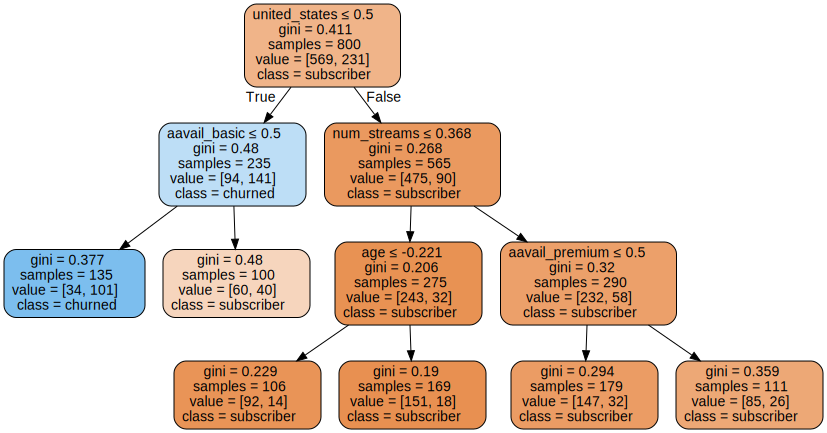

In [14]:
## make plot
try:
    import graphviz        
except:
    print("not creating tree since graphviz is not installed")
    sys.exit()
    
from graphviz import Source
from sklearn.tree import export_graphviz
    
image_dir = os.path.join("..","images")
    
dot_data = export_graphviz(pipe['dt'], 
                           out_file=os.path.join(image_dir, "iris_tree.dot"), feature_names=feature_names,  
                           class_names=target_names,  filled=True, rounded=True,  
                           special_characters=True)

Source.from_file(os.path.join(image_dir, "iris_tree.dot"))

It actually does reasonably well considering the simplicity of the model. Even if this is not a model that would go into production it could be used to inform strategic decision making. Notice how the model naturally identifies the largest subgroup of churned subscribers with only two splits.

In the script above we used `min_sampled_leaf` to prevent the tree from overfitting. The `DecisionTreeClassifier` provides other parameters such as the `max_depth` that can be used. Cost complexity pruning provides another option to control the size of the tree.